# Problem 3


**Question: Suppose you have a detector response that has a bias $f(x) = \sqrt{0.01^2 + (0.01 \exp(-x/4))^2}$. Adjust the "smear" function to be a Gaussian with width 0.03, but with varying mean according to f(x). Given a "true" input Gaussian distribution with mean 0.4 and width 0.1, generate the appropriate measured distribution given the above bias and width. Then unfold that measured distribution and compare to the truth. In effect, you are smearing the true distribution and then unsmearing it to get back where you started ("closure test").**

- Part a:  Plot the "true" distribution and the "measured" distribution after the detector smearing is applied as described above. 
- Part b (Undergrads: 10 points. Grads : 15 points): Unfold the measured distribution with regularization. Show the regularization optimization, and compare the "best" result to the measured and true values in a plot. 

In [1]:
#!/usr/bin/env python
import numpy.linalg as la
import scipy.sparse.linalg as sla
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import copy

# From https://www.researchgate.net/publication/274138835_NumPy_SciPy_Recipes_for_Data_Science_Regularized_Least_Squares_Optimization
def rlsq_solution_V1(X, y, l):
    n, m = X.shape
    I = np.identity(m)
    w = np.dot(np.dot(la.inv(np.dot(X.T, X) + l*I), X.T), y)
    return w

def trivial_invert(X, y) :
    w = np.dot( np.dot( la.inv( np.dot(X.T,X) ), X.T), y )
    return w

### You implement this:
### Detector response smearing function
def smear(x, a, b, s ):
    return s * np.random.randn() + detector_bias(x,a,b)

# You implement this: 
def detector_bias(x, a, b):
    return np.sqrt(a**2 + (a*np.exp(-x/b))**2)

def unsmear(x,a,b,s):
    return (b/2.0)*np.log(np.abs(a**2/((x-s*np.random.randn()) - a**2 )))


In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [3]:

####### Parameters #######

# Mean and width for true distribution
true_val,true_width = 0.4,0.1

# Bin width for matrix:
binwidth = 0.01
# Number of pseudoexperiments to generate response matrix
N_pe = 100000
# Bias (a * (1+exp(-x*b*2.))) and width for Gaussian smearing
a,b = 0.01, 4.0
sigma = 0.03
# Regulate?
regulate = True


### Part a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


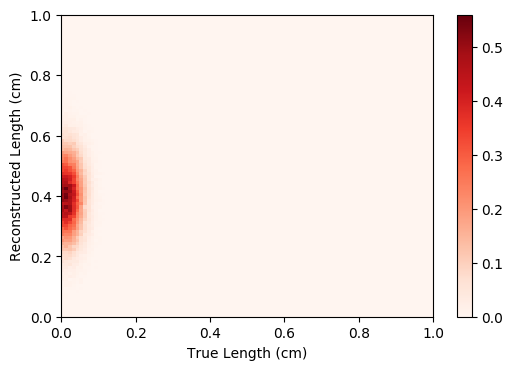

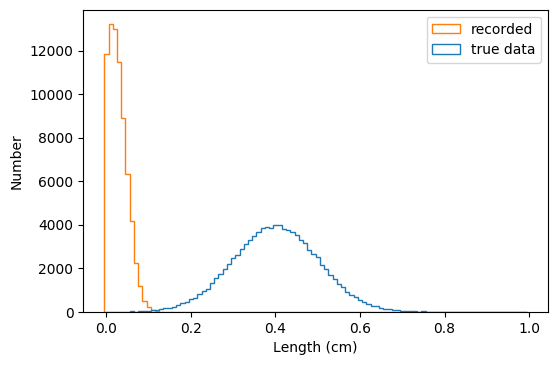

In [4]:

# Create a "truth" distribution
truth = np.random.normal( loc=true_val, scale=true_width, size=N_pe )
# Smear the "truth" distribution
data = np.zeros_like(truth)
for i,datum in enumerate(truth) :
    data[i] = smear(datum,a,b,s=sigma)


### Your code goes here: 
# Create a "measured" distribution
# True values for response matrix
xtrue = true_width*np.random.randn(N_pe) + true_val
xt = np.random.rand(N_pe)
# Smeared values for response matrix
xreco = copy.copy(xt)
for i,x in enumerate(xreco):
    xreco[i] = smear(x,a, b,s=sigma)
# Weights to create response matrix... matplotlib's histograms have unity *integrals*, not response
w = np.ones_like( xt )
w /= N_pe * binwidth
# Values for the x axis ranges
xvals = np.arange(0,1.0,binwidth)
xbins = np.linspace(0,1.0, num=1./binwidth + 1)


##Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(xreco,xtrue, bins=[xbins,xbins], weights=w, cmap='Reds')
plt.xlabel('True Length (cm)')
plt.ylabel('Reconstructed Length (cm)')
plt.colorbar()


# Draw the true and smeared distributions    
plt.figure(2)
returnvals,xbinsout,patches = plt.hist([truth,data],bins=xbins-binwidth*0.5, histtype='step',label=['true data','recorded'])
t = returnvals[0]
d = returnvals[1]
plt.legend()
plt.xlabel('Length (cm)')
plt.ylabel('Number')

# plt.savefig('p3_f1.pdf')
plt.show()


### Part b

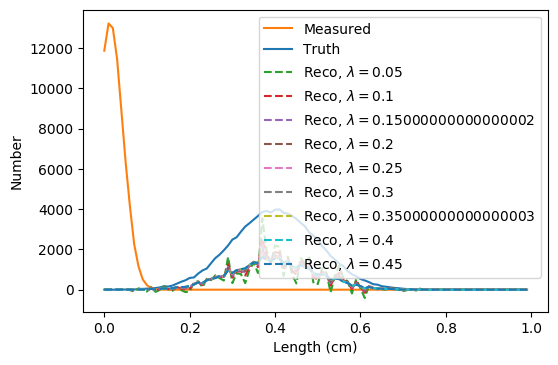

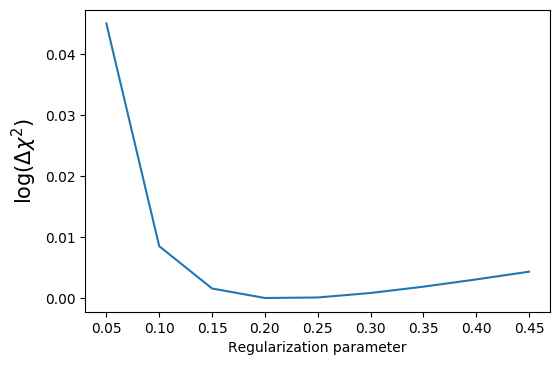

In [6]:
# Draw the true, measured, and reconstructed distributions
plt.figure(3)
truthplot, = plt.plot(xvals, t)
meas, = plt.plot(xvals, d)
toplot = []
if regulate:
    regparams = np.arange(0.05,0.5,0.05)
else :
    regparams = np.zeros(1)
regtitles = [ 'Reco, $\lambda=$' +str(iv) for iv in regparams]
chi2vals = []
for l in regparams:
    if regulate : 
        m = rlsq_solution_V1(G, d, l)
    else :
        m = trivial_invert(G,d)
    reco, = plt.plot(xvals, m, '--')
    toplot.append( reco )
    val = np.log( np.linalg.norm( t-m ) )
    chi2vals.append( val )

plt.legend( [meas,truthplot] + toplot, ['Measured', 'Truth'] + regtitles)
plt.xlabel('Length (cm)')
plt.ylabel('Number')
plt.savefig('p3_f2.pdf')

# Draw the chi2 as a function of regularization parameter
plt.figure(4)
minchi2 = min( chi2vals )
for ichi2,chi2 in enumerate(chi2vals):
    chi2vals[ichi2] -= minchi2
plt.plot( regparams, chi2vals)
plt.xlabel('Regularization parameter')
plt.ylabel(r'$\log(\Delta \chi^2)$', fontsize=15)
plt.savefig("p3_f3.pdf")
plt.show()